# Preparación de los datos

In [1]:
# Importamos librerías a utilizar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

In [2]:
# Para que no se desplieguen las advertencias
warnings.filterwarnings("ignore")

## SIAP

### Cargamos los datos tidy

In [5]:
# Cultivos de interés
cultivos = ['Tomate rojo (jitomate)', 'Chile verde', 'Limón', 'Pepino', 'Plátano', 'Mango', 'Garbanzo', 'Brócoli', 'Cebolla', 'Sandía', 'Papaya', 'Calabacita', 'Lechuga',
            'Tomate verde', 'Espárrago', 'Frambuesa', 'Nopalitos', 'Nuez', 'Fresa', 'Toronja (pomelo)', 'Zarzamora', 'Piña', 'Coliflor', 'Frijol', 'Berenjena', 'Uva', 'Guayaba',
            'Naranja', 'Papa', 'Melón', 'Manzana', 'Pera', 'Durazno']
# Cantidad de cultivos
print(f"Cantidad de cultivos de interés: {len(cultivos)}")

Cantidad de cultivos de interés: 33


In [80]:
# Librería necesaria para cargar parquet
#pip install pyarrow

In [3]:
# URL al archivo parquet en el repositorio
url_siap = r'C:\Users\jcbar\OneDrive\Documentos\Ingeniería de Características\Proyecto\Primera parte\Tidy\SIAP.parquet'
# Cargar archivo parquet como DataFrame
df_siap = pd.read_parquet(url_siap)
# Inspeccionar primeros elementos del DataFrame
df_siap.head()

,Entidad,Municipio,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Anio,Mes,Cultivo
0,Aguascalientes,Aguascalientes,8.00,0.00,0.0,0.00,0,2023,Enero,Agave
1,Baja California Sur,La Paz,3.00,0.00,0.0,0.00,0,2023,Enero,Agave
2,Colima,Manzanillo,86.29,0.00,0.0,0.00,0,2023,Enero,Agave
3,Durango,Durango,13.00,0.00,0.0,0.00,0,2023,Enero,Agave
4,Durango,Mezquital,110.00,0.00,0.0,0.00,0,2023,Enero,Agave


In [8]:
# Nos quedamos solo con los cultivos de interés
df_siap = df_siap[df_siap['Cultivo'].isin(cultivos)]

### Dimensiones de nuestros datos

In [9]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_siap.shape}\n")

Dimensión de los datos: (582752, 10)



### Tipo de dato de cada variable

In [10]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada        object
Superficie Cosechada       object
Superficie Siniestrada    float64
Produccion                 object
Rendimiento                object
Anio                        int64
Mes                        object
Cultivo                    object
dtype: object



(Notamos que las variables *Superficie Sembrada*, *Superficie Cosechada*, *Producción* y *Rendimiento* son de tipo **object**, pese a que su valor es numérico)

Convertimos estas variables object a flotantes

In [11]:
# Lista de variables a convertir
obj_to_float_var = ['Superficie Sembrada', 'Superficie Cosechada', 'Produccion', 'Rendimiento']
# Eliminación de ',' character y conversión a flotante
for var in obj_to_float_var:
    df_siap[var] = df_siap[var].str.replace(',','').astype('float')

Re-evaluamos los tipos de datos

In [12]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada       float64
Superficie Cosechada      float64
Superficie Siniestrada    float64
Produccion                float64
Rendimiento               float64
Anio                        int64
Mes                        object
Cultivo                    object
dtype: object



### Estadísticos descriptivos de nuestros datos

In [13]:
# Estadísticos descriptivos ignorando la columna Anio
df_siap.loc[:, df_siap.columns != 'Anio'].describe().applymap('{:,.2f}'.format)

,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento
count,"582,752.00","582,752.00","582,464.00","582,752.00","582,752.00"
mean,299.44,166.83,0.73,"2,123.56",12.91
std,"1,823.73","1,146.69",15.35,"12,587.49",29.02
min,0.00,0.00,0.00,0.00,0.00
25%,7.00,0.00,0.00,0.00,0.00
50%,24.00,5.50,0.00,37.40,3.16
75%,100.00,40.00,0.00,416.00,15.40
max,"120,900.00","119,950.00",990.00,"794,461.81",696.43


### Valores faltantes

In [14]:
# Valores faltantes
print(f"Valores faltantes:\n {df_siap.isna().sum()}")

Valores faltantes:
 Entidad                     0
Municipio                   0
Superficie Sembrada         0
Superficie Cosechada        0
Superficie Siniestrada    288
Produccion                  0
Rendimiento                 0
Anio                        0
Mes                         0
Cultivo                     0
dtype: int64


### Datos repetidos

In [15]:
# Filas repetidas
print(f"Cantidad de filas repetidas: {df_siap.duplicated().sum()}")

Cantidad de filas repetidas: 0


### Pandas profiling

In [89]:
# Código para obtener un super resumen automático de los datos

# ! pip install -U ydata-profiling
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile.to_notebook_iframe()

### 1. ¿En qué épocas del año es más probable que se generen excedentes? 

**Producción mensual acumulada**

El SIAP provee los datos de manera mensual acumulada. Es decir, la producción de Febrero contiene la producción de Enero y Febrero. La producción de Marzo contiene la producción de Enero, Febrero y Marzo; y así sucesivamente.  

In [92]:
# Agrupamos por año y por mes, y sumamos la produccion
prod_año_mes = df_siap.groupby(['Anio', 'Mes'])['Produccion'].sum()
prod_año_mes

Anio  Mes       
2018  Abril         10165366.29
      Agosto        21711429.80
      Diciembre     32612489.63
      Enero          1842999.69
      Febrero        4363652.79
                       ...     
2023  Julio         21669332.78
      Junio         18830705.91
      Marzo          8737073.24
      Mayo          15518996.40
      Septiembre    28245742.52
Name: Produccion, Length: 69, dtype: float64

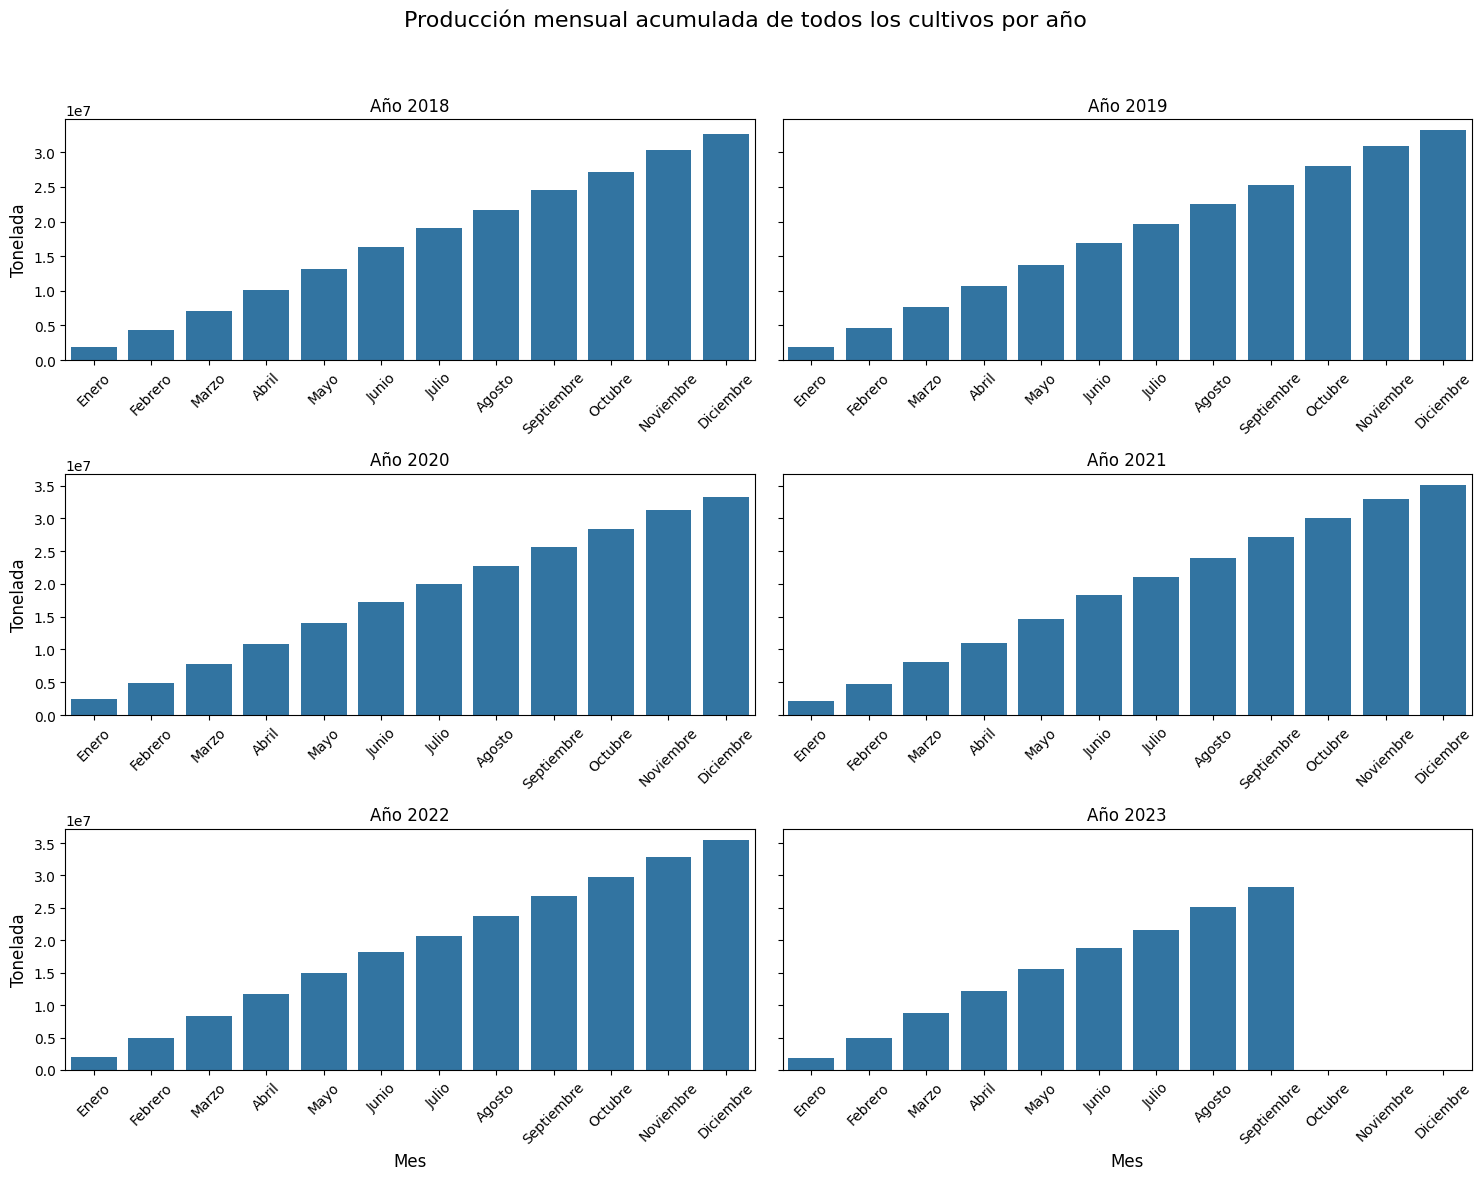

In [146]:
# Crea una figura con una matriz de subgráficas 3x2
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharey='row')
fig.suptitle('Producción mensual acumulada de todos los cultivos por año', fontsize=16)


# Orden cronológico de los meses
meses_cronologico = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

i=0

# Itera a través de los años y crea una subgráfica para cada uno
for year in prod_año_mes.index.get_level_values('Anio').unique():
    row, col = i // 2, i % 2  # Calcula la fila y la columna actual en la matriz de subgráficas
    ax = axes[row, col]  # Selecciona la subgráfica actual
    
    # Filtra los datos para el año actual y reordena los meses cronológicamente
    df_year = prod_año_mes.loc[year].reindex(meses_cronologico)
    
    # Crea un gráfico de barras en la subgráfica actual
    sns.barplot(x=df_year.index, y=df_year.values, ci=None, ax=ax)
    
    # Personaliza la subgráfica
    ax.set_title(f'Año {year}')
    
    # Agrega etiquetas en el eje Y solo a las gráficas de la izquierda
    if col == 0:
        ax.set_ylabel('Tonelada', fontsize=12)

    # Agrega etiquetas en el eje X solo a las gráficas de abajo
    if row == 2:
        ax.set_xlabel('Mes', fontsize=12)
    else:
        ax.set_xlabel('', fontsize=12)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rota las etiquetas del eje X

    i+=1
    
# Ajusta el diseño de las subgráficas
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Muestra la figura
plt.show()

**Producción mensual no acumulada**

Para observar la verdadera producción de cada mes, calculamos la producción de cada mes, menos la producción de todos los meses previos.

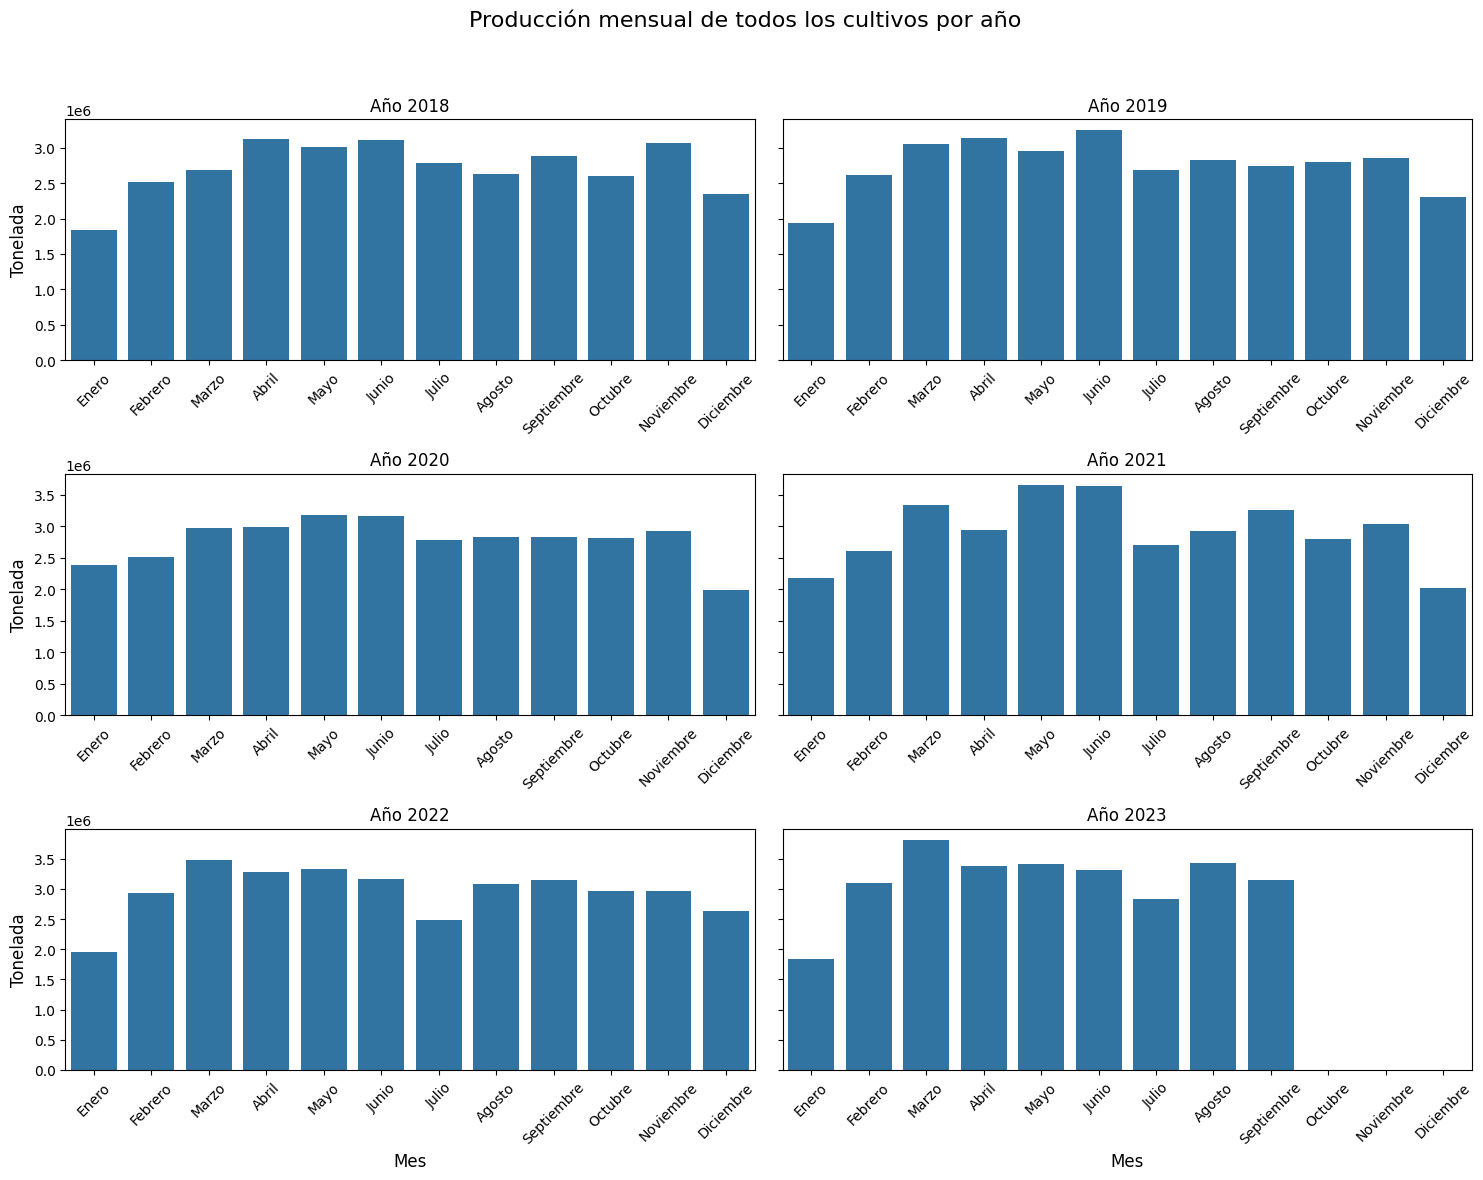

In [145]:
# Crear una figura con una matriz de subgráficas 3x2
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharey='row')
fig.suptitle('Producción mensual de todos los cultivos por año', fontsize=16)

# Orden cronológico de los meses
meses_cronologico = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

i = 0

# Iterar a través de los años y crear una subgráfica para cada uno
for year in prod_año_mes.index.get_level_values('Anio').unique():
    row, col = i // 2, i % 2  # Calcular la fila y la columna actual en la matriz de subgráficas
    ax = axes[row, col]  # Seleccionar la subgráfica actual

    # Filtrar los datos para el año actual y reordenar los meses cronológicamente
    df_year = prod_año_mes.loc[year].reindex(meses_cronologico)
    
    # Calcular la producción mensual sin incluir la de los meses previos
    df_monthly = df_year.diff().fillna(df_year)
    
    # Crear un gráfico de barras en la subgráfica actual
    sns.barplot(x=df_monthly.index, y=df_monthly.values, ci=None, ax=ax)
    
    # Personalizar la subgráfica
    ax.set_title(f'Año {year}')
    
    # Agregar etiquetas en el eje Y solo a las gráficas de la izquierda
    if col == 0:
        ax.set_ylabel('Tonelada', fontsize=12)

    # Agregar etiquetas en el eje X solo a las gráficas de abajo
    if row == 2:
        ax.set_xlabel('Mes', fontsize=12)
    else:
        ax.set_xlabel('', fontsize=12)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotar las etiquetas del eje X

    i += 1

# Ajustar el diseño de las subgráficas
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Mostrar la figura
plt.show()

Gráficamos nuevamente, pero ahora ordenando en términos de producción.

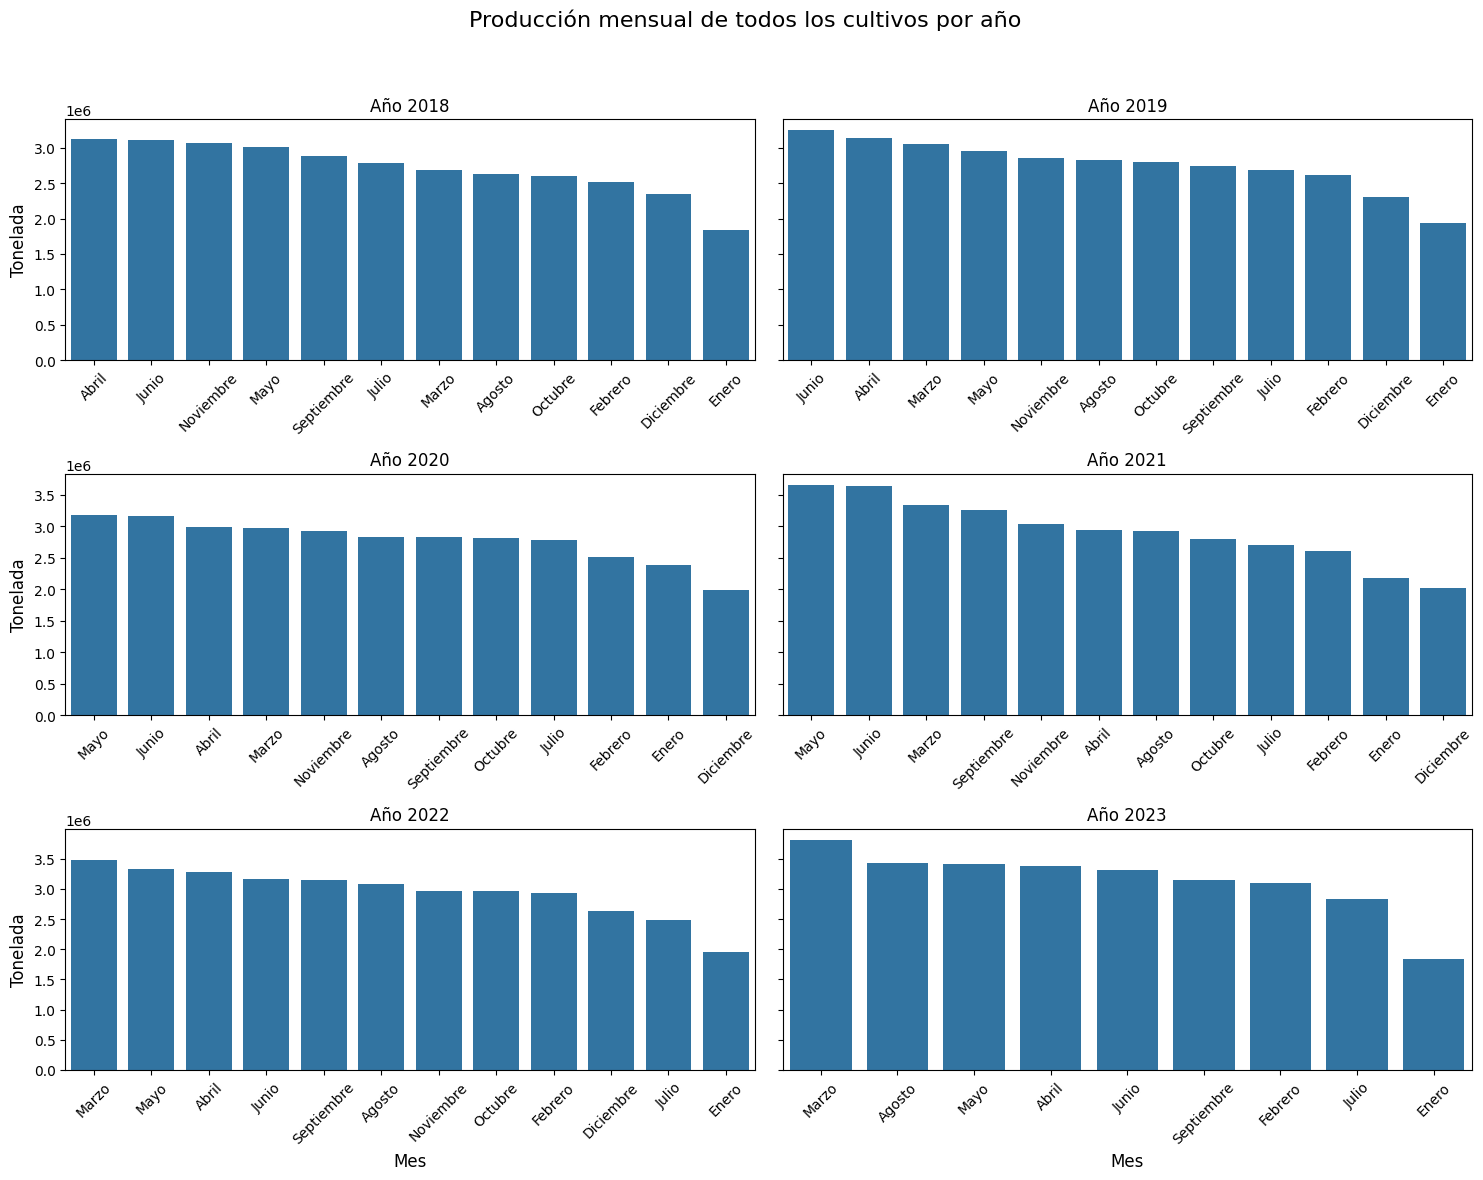

In [144]:
# Crear una figura con una matriz de subgráficas 3x2
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharey='row')
fig.suptitle('Producción mensual de todos los cultivos por año', fontsize=16)

# Orden cronológico de los meses
meses_cronologico = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

i = 0

# Iterar a través de los años y crear una subgráfica para cada uno
for year in prod_año_mes.index.get_level_values('Anio').unique():
    row, col = i // 2, i % 2  # Calcular la fila y la columna actual en la matriz de subgráficas
    ax = axes[row, col]  # Seleccionar la subgráfica actual

    # Filtrar los datos para el año actual y reordenar los meses cronológicamente
    df_year = prod_año_mes.loc[year].sort_values()
    
    # Calcular la producción mensual sin incluir la de los meses previos
    df_monthly = df_year.diff().fillna(df_year).sort_values(ascending=False)
    
    # Crear un gráfico de barras en la subgráfica actual
    sns.barplot(x=df_monthly.index, y=df_monthly.values, ci=None, ax=ax)
    
    # Personalizar la subgráfica
    ax.set_title(f'Año {year}')
    
    # Agregar etiquetas en el eje Y solo a las gráficas de la izquierda
    if col == 0:
        ax.set_ylabel('Tonelada', fontsize=12)

    # Agregar etiquetas en el eje X solo a las gráficas de abajo
    if row == 2:
        ax.set_xlabel('Mes', fontsize=12)
    else:
        ax.set_xlabel('', fontsize=12)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotar las etiquetas del eje X

    i += 1

# Ajustar el diseño de las subgráficas
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Mostrar la figura
plt.show()

### 2. ¿En qué localidades hay mayor probabilidad de acumulación de excedentes?

**Producción anual por estado**

*Retomando el hecho de que el SIAP arroja la producción de manera acumulativa, para saber la producción que hubo en un año particular basta con extraer la producción asociada al mes de diciembre de dicho año*

In [124]:
# Agrupamos por año y por cultivo, y sumamos la produccion
prod_año_estado = df_siap[df_siap['Mes'] == 'Diciembre'].groupby(['Anio', 'Entidad'])['Produccion'].sum()
prod_año_estado

Anio  Entidad            
2018  Aguascalientes          247491.77
      Baja California         509258.12
      Baja California Sur     381554.74
      Campeche                192757.22
      Chiapas                1408548.91
                                ...    
2022  Tamaulipas             1233951.16
      Tlaxcala                 82497.48
      Veracruz               5435710.51
      Yucatán                 388565.36
      Zacatecas              1601359.47
Name: Produccion, Length: 160, dtype: float64

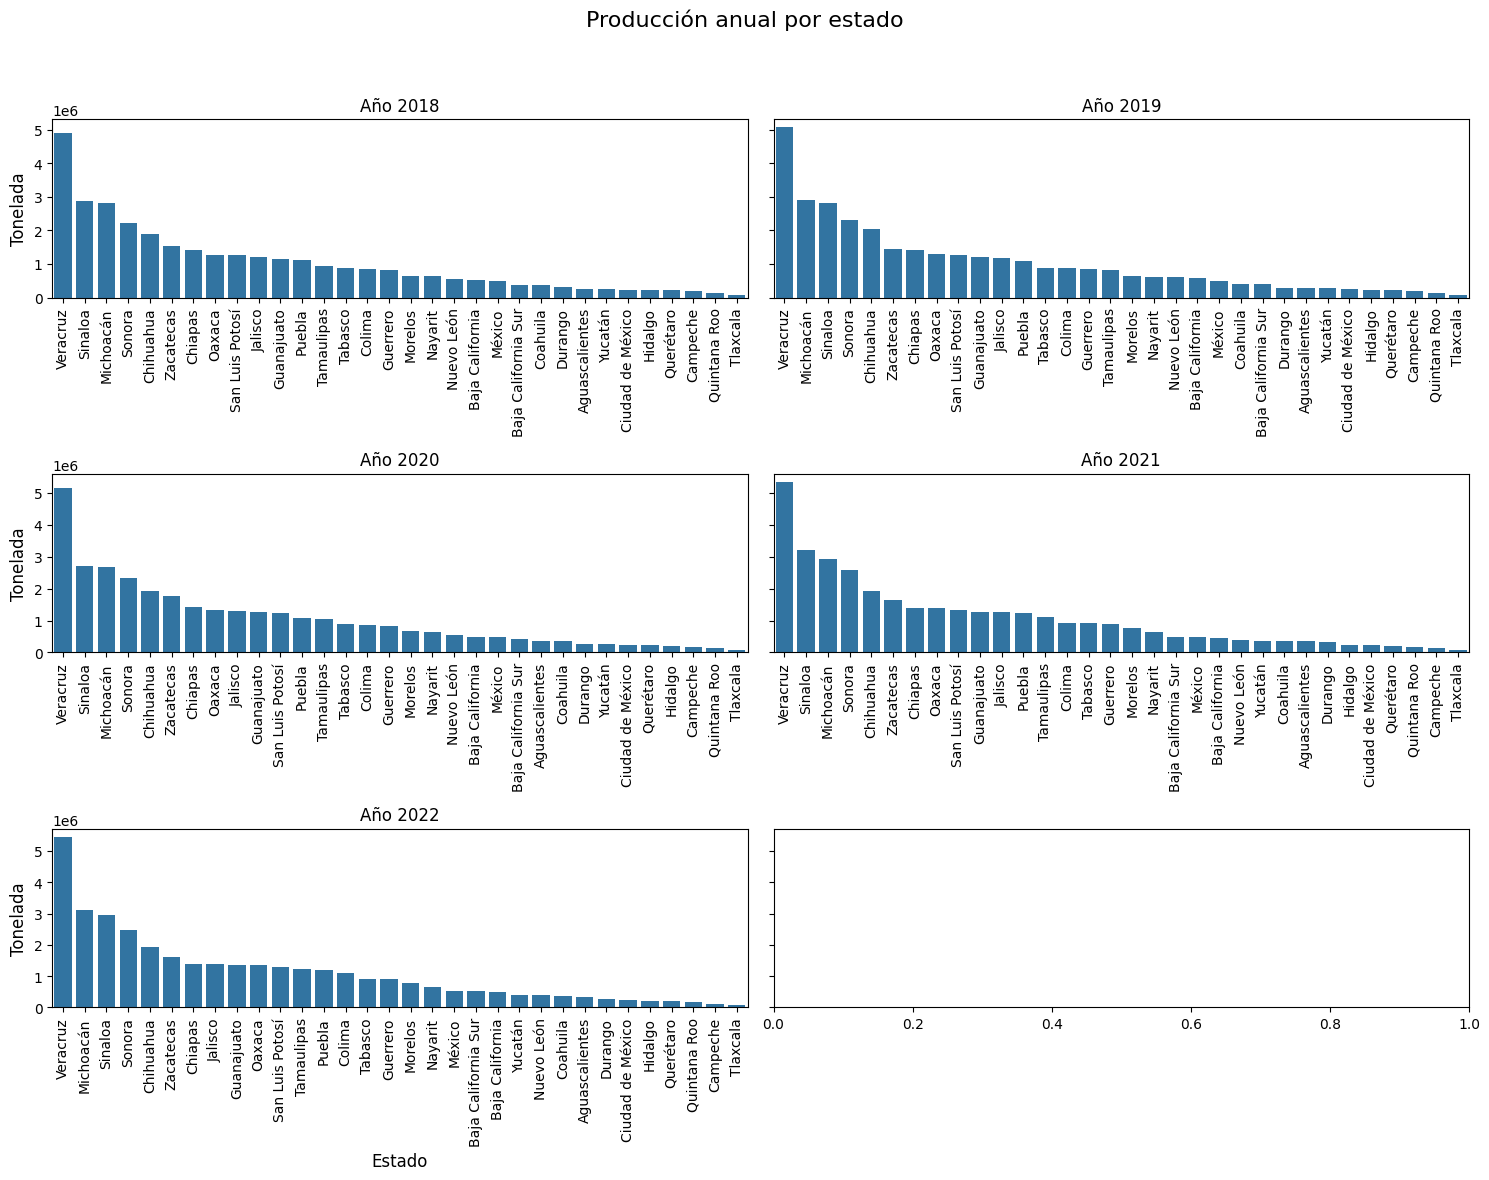

In [154]:
# Crea una figura con una matriz de subgráficas 3x2
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharey='row')
fig.suptitle('Producción anual por estado', fontsize=16)

i=0

# Itera a través de los años y crea una subgráfica para cada uno
for year in prod_año_estado.index.get_level_values('Anio').unique():
    row, col = i // 2, i % 2  # Calcula la fila y la columna actual en la matriz de subgráficas
    ax = axes[row, col]  # Selecciona la subgráfica actual
    
    # Filtra los datos para el año actual y reordena los meses cronológicamente
    df_year = prod_año_estado.loc[year].sort_values(ascending=False)
    
    # Crea un gráfico de barras en la subgráfica actual
    sns.barplot(x=df_year.index, y=df_year.values, ci=None, ax=ax)
    
    # Personaliza la subgráfica
    ax.set_title(f'Año {year}')
    
    # Agrega etiquetas en el eje Y solo a las gráficas de la izquierda
    if col == 0:
        ax.set_ylabel('Tonelada', fontsize=12)

    # Agrega etiquetas en el eje X solo a las gráficas de abajo
    if row == 2:
        ax.set_xlabel('Estado', fontsize=12)
    else:
        ax.set_xlabel('', fontsize=12)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rota las etiquetas del eje X

    i+=1
    
# Ajusta el diseño de las subgráficas
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Muestra la figura
plt.show()

**Producción anual por municipio**

In [136]:
# Agrupamos por año y por cultivo, y sumamos la produccion
prod_est_año_mun = df_siap[df_siap['Mes'] == 'Diciembre'].groupby(['Entidad', 'Anio', 'Municipio'])['Produccion'].sum()
prod_est_año_mun

Entidad         Anio  Municipio            
Aguascalientes  2018  Aguascalientes             5080.86
                      Asientos                  93836.54
                      Calvillo                  70864.10
                      Cosío                     12076.90
                      El Llano                   1595.71
                                                 ...    
Zacatecas       2022  Villa González Ortega      6919.51
                      Villa Hidalgo             27454.74
                      Villa de Cos             176253.53
                      Villanueva                13626.20
                      Zacatecas                 12386.20
Name: Produccion, Length: 11363, dtype: float64

In [139]:
# Seleccionamos el estado
estado = 'Sonora'
prod_año_mun = prod_est_año_mun.loc[estado]

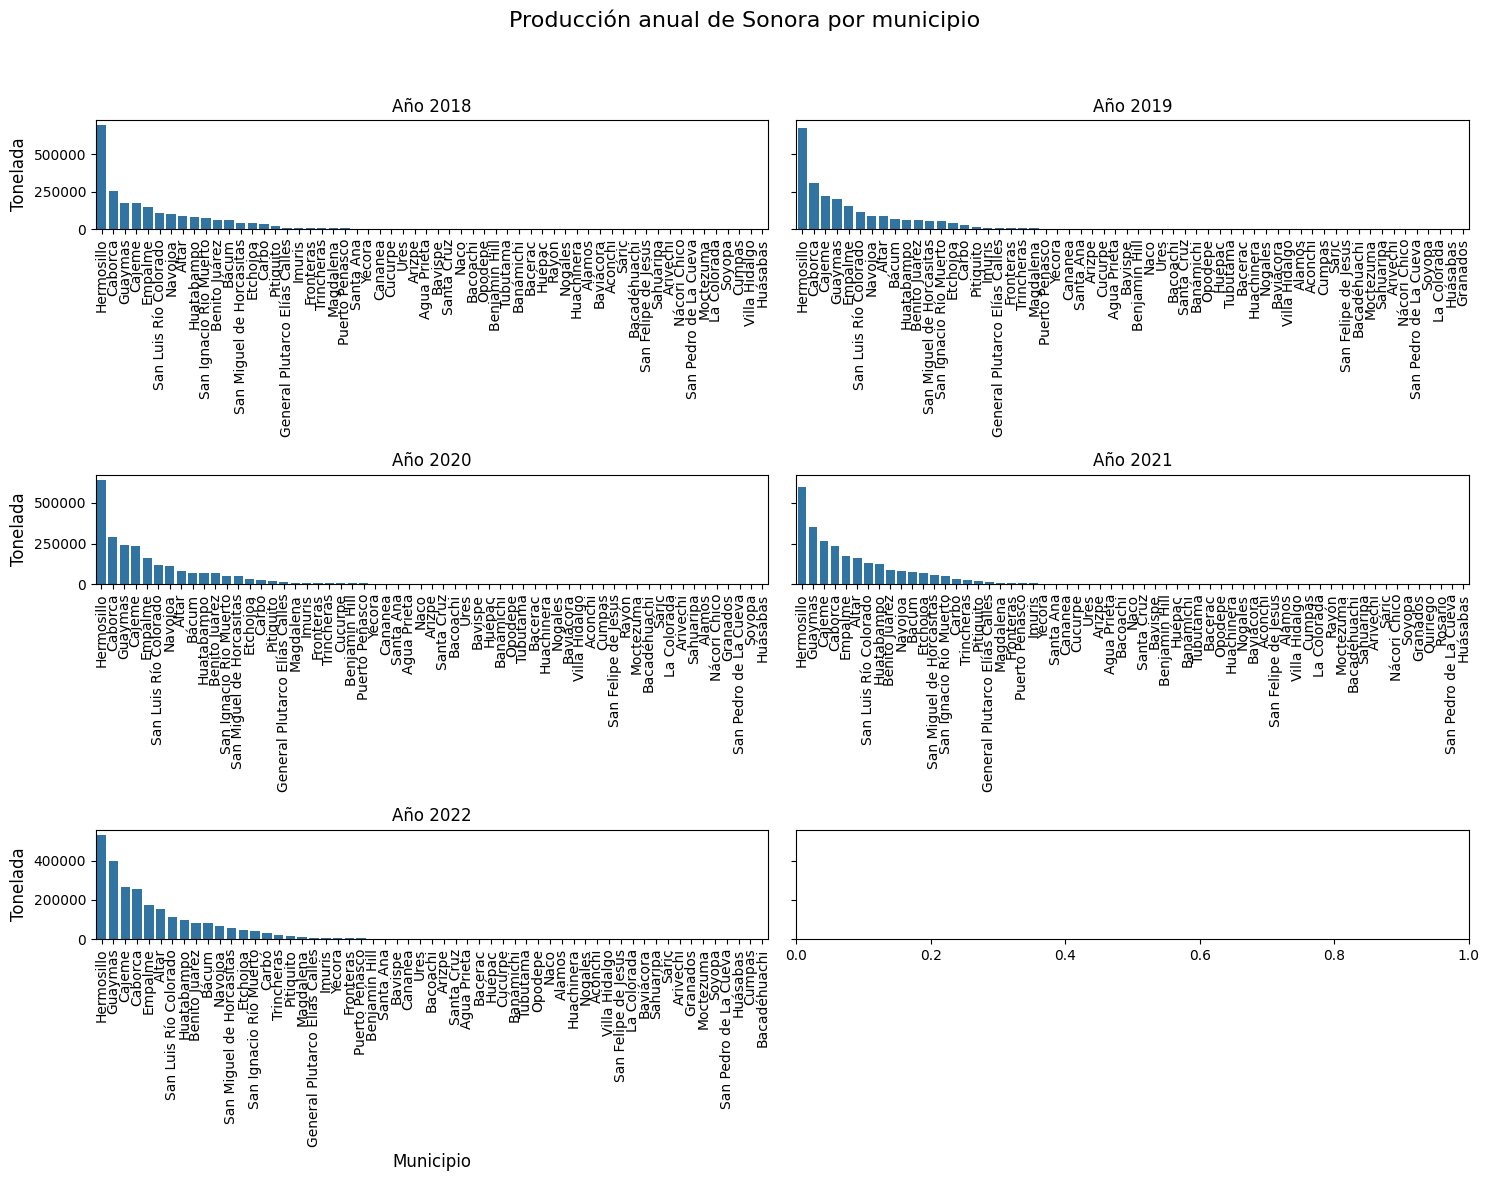

In [141]:
# Crea una figura con una matriz de subgráficas 3x2
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharey='row')
fig.suptitle(f'Producción anual de {estado} por municipio', fontsize=16)

i=0

# Itera a través de los años y crea una subgráfica para cada uno
for year in prod_año_mun.index.get_level_values('Anio').unique():
    row, col = i // 2, i % 2  # Calcula la fila y la columna actual en la matriz de subgráficas
    ax = axes[row, col]  # Selecciona la subgráfica actual
    
    # Filtra los datos para el año actual y reordena los meses cronológicamente
    df_year = prod_año_mun.loc[year].sort_values(ascending=False)
    
    # Crea un gráfico de barras en la subgráfica actual
    sns.barplot(x=df_year.index, y=df_year.values, ci=None, ax=ax)
    
    # Personaliza la subgráfica
    ax.set_title(f'Año {year}')
    
    # Agrega etiquetas en el eje Y solo a las gráficas de la izquierda
    if col == 0:
        ax.set_ylabel('Tonelada', fontsize=12)

    # Agrega etiquetas en el eje X solo a las gráficas de abajo
    if row == 2:
        ax.set_xlabel('Municipio', fontsize=12)
    else:
        ax.set_xlabel('', fontsize=12)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rota las etiquetas del eje X

    i+=1
    
# Ajusta el diseño de las subgráficas
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Muestra la figura
plt.show()

### 3. ¿Qué cultivos tienen mayor tendencia a ser producidos excesivamente?

**Producción anual por cultivo**

In [117]:
# Agrupamos por año y por cultivo, y sumamos la produccion
prod_año_cult = df_siap[df_siap['Mes'] == 'Diciembre'].groupby(['Anio', 'Cultivo'])['Produccion'].sum()
prod_año_cult

Anio  Cultivo               
2018  Berenjena                  187883.03
      Brócoli                    618571.57
      Cebolla                   1450137.24
      Chile verde               3239318.30
      Coliflor                    89981.99
                                   ...    
2022  Tomate rojo (jitomate)    3185507.70
      Tomate verde               735863.50
      Toronja (pomelo)           489100.97
      Uva                        477318.60
      Zarzamora                  222623.05
Name: Produccion, Length: 154, dtype: float64

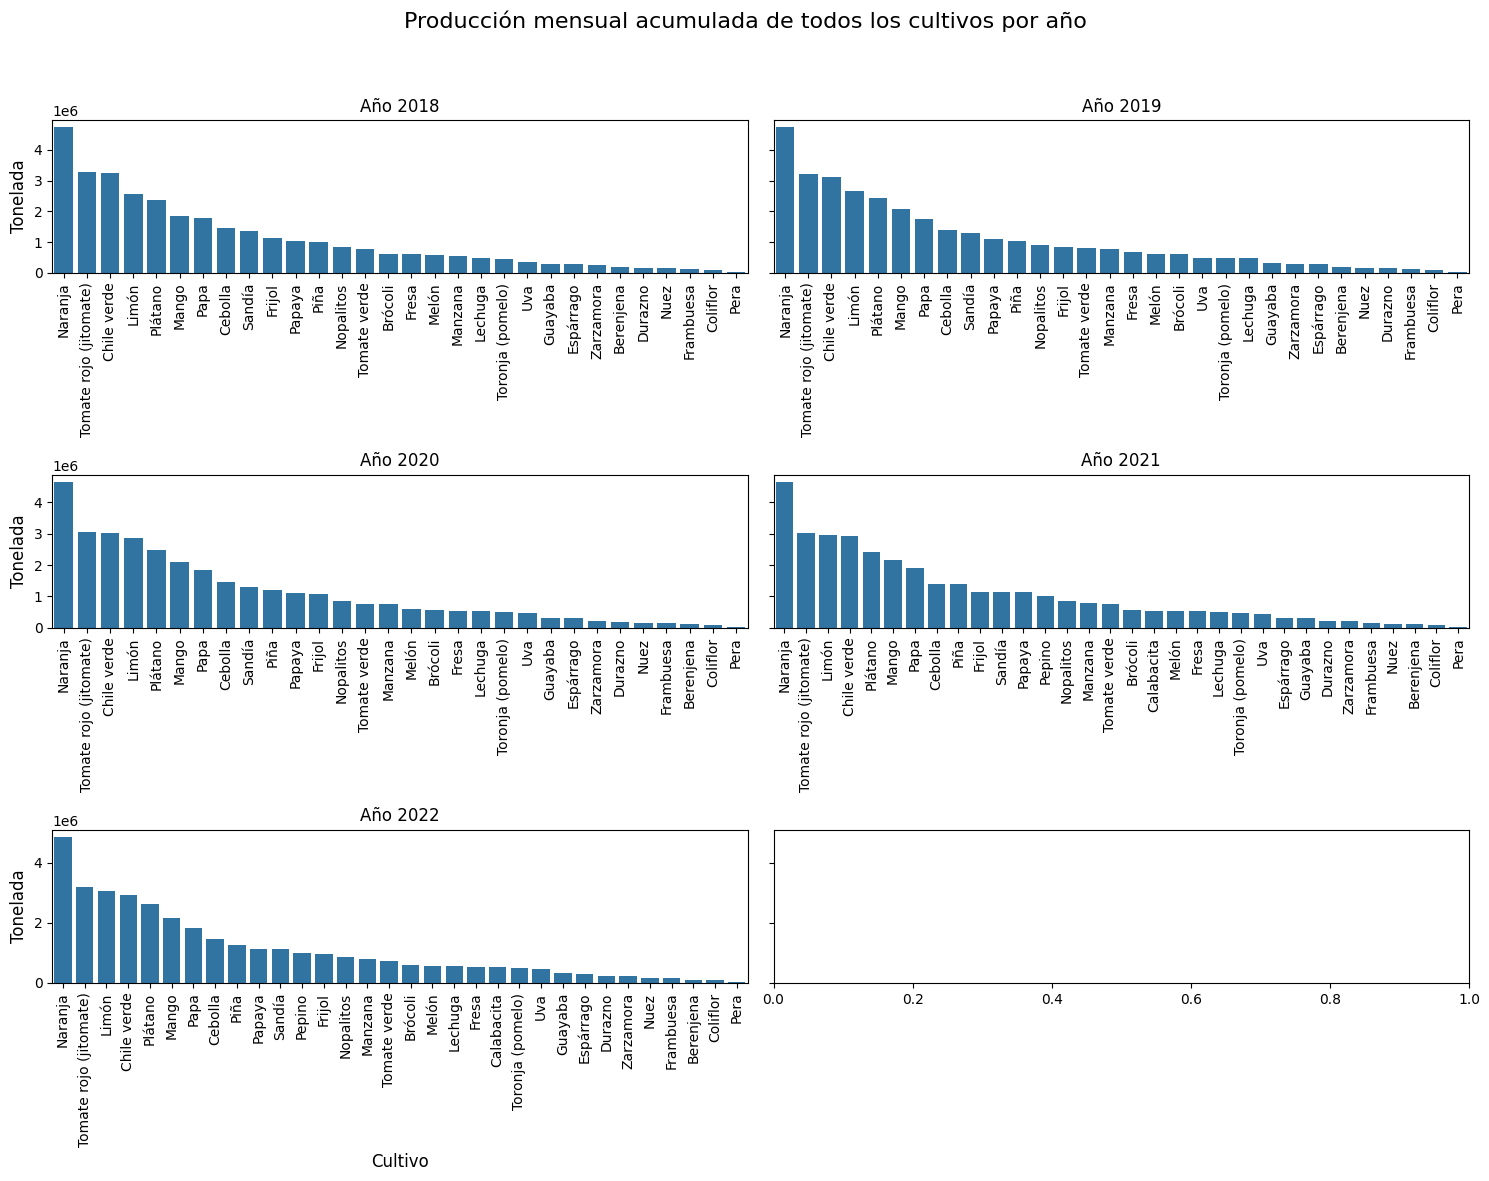

In [147]:
# Crea una figura con una matriz de subgráficas 3x2
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharey='row')
fig.suptitle('Producción mensual acumulada de todos los cultivos por año', fontsize=16)

i=0

# Itera a través de los años y crea una subgráfica para cada uno
for year in prod_año_cult.index.get_level_values('Anio').unique():
    row, col = i // 2, i % 2  # Calcula la fila y la columna actual en la matriz de subgráficas
    ax = axes[row, col]  # Selecciona la subgráfica actual
    
    # Filtra los datos para el año actual y reordena los meses cronológicamente
    df_year = prod_año_cult.loc[year].sort_values(ascending=False)
    
    # Crea un gráfico de barras en la subgráfica actual
    sns.barplot(x=df_year.index, y=df_year.values, ci=None, ax=ax)
    
    # Personaliza la subgráfica
    ax.set_title(f'Año {year}')
    
    # Agrega etiquetas en el eje Y solo a las gráficas de la izquierda
    if col == 0:
        ax.set_ylabel('Tonelada', fontsize=12)

    # Agrega etiquetas en el eje X solo a las gráficas de abajo
    if row == 2:
        ax.set_xlabel('Cultivo', fontsize=12)
    else:
        ax.set_xlabel('', fontsize=12)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rota las etiquetas del eje X

    i+=1
    
# Ajusta el diseño de las subgráficas
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Muestra la figura
plt.show()